여기에 필요한 모델 등 저장된 파일이 있는데, 너무 용량이 큰 관계로 함께 제출하지 않았습니다. 따라서 이 notebook은 작동하지 않을 것입니다. (Report에 들어있는 그래프를 만들기 위해 사용된 코드입니다)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd

# Preparation

In [2]:
dict_idx_movieId = pickle.load(open('./saved/dict_idx_movieId.pkl', "rb"))
dict_movieId_idx = pickle.load(open('./saved/dict_movieId_idx.pkl', "rb"))
dict_idx_userId = pickle.load(open('./saved/dict_idx_userId.pkl', "rb"))
dict_userId_idx = pickle.load(open('./saved/dict_userId_idx.pkl', "rb"))

In [3]:
df_rating_val = pd.read_csv('./data/ratings_val.csv')
df_rating_train = pd.read_csv('./data/ratings_train.csv')

all_movieId = []
all_userId = []

for i in range(len(df_rating_train)):
    all_movieId.append(df_rating_train["movieId"][i])
    all_userId.append(df_rating_train["userId"][i])

all_movieId = set(all_movieId)
all_userId = set(all_userId)

all_movieId = sorted(all_movieId)
all_userId = sorted(all_userId)

val_userId = []
val_movieId = []

for i in range(len(df_rating_val)):
    val_userId.append(df_rating_val["userId"][i])
    val_movieId.append(df_rating_val["movieId"][i])

val_userId = sorted(set(val_userId))
val_movieId = sorted(set(val_movieId))

In [4]:
both_userId = []
for i in val_userId:
    if i in all_userId:
        print(i, end= " ")
        both_userId.append(i)

print()
print()

for i in val_movieId:
    if i in all_movieId:
        print(i, end=" ")

15 48 68 73 78 157 163 199 257 275 380 427 458 480 529 547 599 624 637 648 

1 2 3 5 6 7 10 11 14 16 17 19 22 25 28 29 31 32 34 36 39 47 48 50 52 58 60 62 63 69 70 73 88 97 101 104 105 110 111 112 117 122 125 126 141 145 150 153 154 158 162 163 165 166 169 170 173 175 178 180 185 193 196 198 204 207 208 215 216 223 224 231 232 233 235 236 246 247 253 256 260 261 262 265 266 267 277 288 292 293 296 300 306 307 308 316 317 318 319 329 333 337 339 342 344 347 348 349 353 355 356 357 362 363 364 365 367 370 374 376 377 380 381 410 413 419 420 431 440 441 442 444 454 455 457 466 471 474 475 480 482 485 488 492 494 495 500 501 502 508 509 520 527 529 532 538 539 540 541 551 552 555 556 562 581 585 586 587 588 589 590 592 593 594 595 596 597 599 605 608 610 616 628 648 661 673 678 707 708 709 714 719 720 724 733 736 741 743 745 750 762 765 778 780 783 784 785 786 788 799 802 805 838 839 841 849 852 858 898 899 900 903 904 905 908 909 910 911 912 913 914 916 918 919 920 921 922 923 924 926 928

In [5]:
new_bothuserId = []
str_bothuserId = []
for i in both_userId:
    if i != 427:
        new_bothuserId.append(i)

new_bothuserId = sorted(new_bothuserId)

for i in new_bothuserId:
    str_bothuserId.append(str(i))

In [6]:
dict_val_rating = {}

for i in val_userId:
    dict_val_rating[i] = {}

for i in range(len(df_rating_val)):
    c_user = df_rating_val["userId"][i]
    dict_val_rating[c_user][df_rating_val["movieId"][i]] = df_rating_val["rating"][i]

In [7]:
movie = np.load('saved/movie_f.npy')
mu = np.load('saved/mu_f.npy')
user = np.load('saved/user_f.npy')

k = 400
movie_k = movie[:, :k]
mu_k = mu[:k]
user_k = user[:k]

# Learning Rate Test

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
#https://pytorch.org/functorch/stable/notebooks/ensembling.html
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(800,256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 400)

    def forward(self, x):
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

In [10]:
class all_neumf(nn.Module):
#https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
    def __init__(self):
        super(all_neumf, self).__init__()
        self.mlp = MLP()
        self.neumf = nn.Linear(800, 1)
    
    def forward(self, x, y):
        x = self.mlp(x)
        x = torch.cat((y, x), 1)
        x = self.neumf(x)
        x = F.relu(x)
        return x        
    

In [11]:
##https://eehoeskrap.tistory.com/618
lr_001 = all_neumf()
lr_0001 = all_neumf()
lr_00001 = all_neumf()

lr_001.load_state_dict(torch.load('saved_models/neuCF_10_lr0.001_m0.9'))
lr_0001.load_state_dict(torch.load('saved_models/neuCF_10_lr0.0001_m0.9'))
lr_00001.load_state_dict(torch.load('saved_models/neuCF_10_lr0.00001_m0.9'))

lr_001.to(device)
lr_0001.to(device)
lr_00001.to(device)

all_neumf(
  (mlp): MLP(
    (fc1): Linear(in_features=800, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=400, bias=True)
  )
  (neumf): Linear(in_features=800, out_features=1, bias=True)
)

In [12]:
def test_rating_neumf(userId, movieId, model):
    curr_useridx = dict_userId_idx[userId]
    curr_movieidx = dict_movieId_idx[movieId]

    test_input = np.zeros((3*k, ))
    test_input[:k] = np.multiply(movie_k[curr_movieidx], user_k[:, curr_useridx])

    test_input[k : k*2] = movie_k[curr_movieidx]
    test_input[k*2 : ] = user_k[:, curr_useridx]
    test_input = np.array([test_input])

    test_input = torch.Tensor(test_input)
    test_input = test_input.to(device)
    
    return model(test_input[:, k:], test_input[:, :k])

In [13]:
#https://velog.io/@hyesoup/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%ED%9A%8C%EA%B7%80-%EB%AA%A8%EB%8D%B8%EC%9D%98-%EC%84%B1%EB%8A%A5-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-MAE-MSE-RMSE-R-squred

def RMSE_neuf(userId, model):
    curr_dict = dict_val_rating[userId]
    count_n = 0
    square_sum = 0
    
    for i in curr_dict.keys():
        curr_movieId = i
        curr_rating = curr_dict[i]
        
        try: 
            curr_output = test_rating_neumf(userId, curr_movieId, model).cpu().detach().numpy()
            square_sum += (curr_output - curr_rating)**2
            count_n += 1

        except KeyError:
            pass
    
    return np.sqrt(square_sum/count_n)

In [14]:
rmse_lr001 = []
rmse_lr0001 = []
rmse_lr00001 = []

for i in new_bothuserId:
    rmse_lr001.append(RMSE_neuf(i, lr_001)[0][0])
    rmse_lr0001.append(RMSE_neuf(i, lr_0001)[0][0])
    rmse_lr00001.append(RMSE_neuf(i, lr_00001)[0][0])

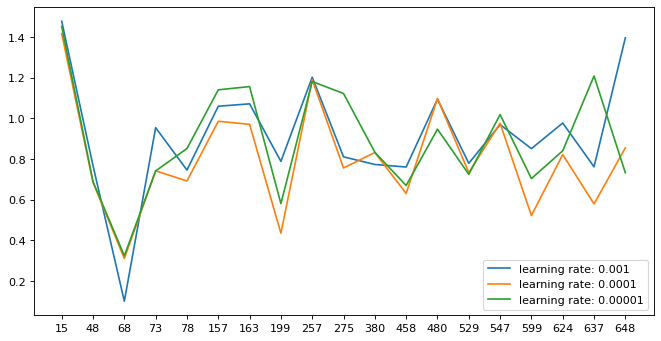

In [15]:
#https://pyvisuall.tistory.com/71
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(str_bothuserId, rmse_lr001, label = "learning rate: 0.001")
plt.plot(str_bothuserId, rmse_lr0001, label = "learning rate: 0.0001")
plt.plot(str_bothuserId, rmse_lr00001, label = "learning rate: 0.00001")
plt.legend()
plt.show()

In [16]:
print(np.mean(rmse_lr001))
print(np.mean(rmse_lr0001))
print(np.mean(rmse_lr00001))

0.9120821
0.8010199
0.88976306


# Input Difference

In [23]:
class MLP_input128(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(800,128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 400)

    def forward(self, x):
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x
    
class all_neumf_input128(nn.Module):
#https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
    def __init__(self):
        super(all_neumf_input128, self).__init__()
        self.mlp = MLP_input128()
        self.neumf = nn.Linear(800, 1)
    
    def forward(self, x, y):
        x = self.mlp(x)
        x = torch.cat((y, x), 1)
        x = self.neumf(x)
        x = F.relu(x)
        return x        

In [24]:
class MLP_input512(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(800,512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 400)

    def forward(self, x):
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x
    
class all_neumf_input512(nn.Module):
#https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
    def __init__(self):
        super(all_neumf_input512, self).__init__()
        self.mlp = MLP_input512()
        self.neumf = nn.Linear(800, 1)
    
    def forward(self, x, y):
        x = self.mlp(x)
        x = torch.cat((y, x), 1)
        x = self.neumf(x)
        x = F.relu(x)
        return x        

In [27]:
class MLP_input1024(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(800,1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 400)

    def forward(self, x):
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x
    
class all_neumf_input1024(nn.Module):
    def __init__(self):
        super(all_neumf_input1024, self).__init__()
        self.mlp = MLP_input1024()
        self.neumf = nn.Linear(800, 1)
    
    def forward(self, x, y):
        x = self.mlp(x)
        x = torch.cat((y, x), 1)
        x = self.neumf(x)
        x = F.relu(x)
        return x        

In [28]:
input128 = all_neumf_input128()
input512 = all_neumf_input512()
input1024 = all_neumf_input1024()

input128.load_state_dict(torch.load('saved_models/neuCF_10_lr0.0001_m0.9_input128'))
input512.load_state_dict(torch.load('saved_models/neuCF_10_lr0.0001_m0.9_input512'))
input1024.load_state_dict(torch.load('saved_models/neuCF_10_lr0.0001_m0.9_input1024'))

input128.to(device)
input512.to(device)
input1024.to(device)

all_neumf_input1024(
  (mlp): MLP_input1024(
    (fc1): Linear(in_features=800, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=400, bias=True)
  )
  (neumf): Linear(in_features=800, out_features=1, bias=True)
)

In [29]:
rmse_input128 = []
rmse_input512 = []
rmse_input1024 = []

for i in new_bothuserId:
    rmse_input128.append((RMSE_neuf(i, input128)[0][0]))
    rmse_input512.append((RMSE_neuf(i, input512)[0][0]))
    rmse_input1024.append((RMSE_neuf(i, input1024)[0][0]))

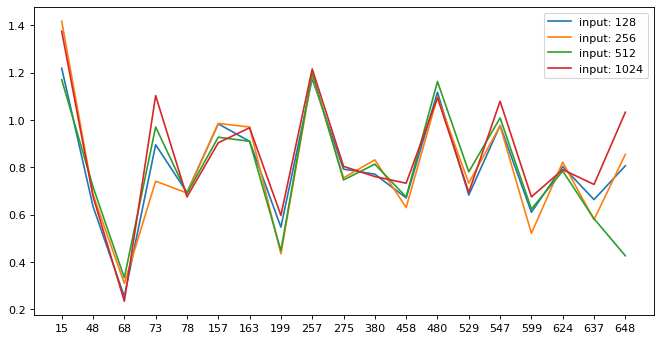

In [30]:
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(str_bothuserId, rmse_input128, label = "input: 128")
plt.plot(str_bothuserId, rmse_lr0001, label = "input: 256")
plt.plot(str_bothuserId, rmse_input512, label = "input: 512")
plt.plot(str_bothuserId, rmse_input1024, label = "input: 1024")
plt.legend()
plt.show()

In [32]:
print(np.mean(rmse_input128))
print(np.mean(rmse_lr0001))
print(np.mean(rmse_input512))
print(np.mean(rmse_input1024))

0.80010843
0.8010199
0.78765357
0.84923905


# Layer Difference

In [33]:
class MLP_layer2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(800,512)
        self.fc2 = nn.Linear(512, 400)

    def forward(self, x):
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x
    
class all_neumf_layer2(nn.Module):
    def __init__(self):
        super(all_neumf_layer2, self).__init__()
        self.mlp = MLP_layer2()
        self.neumf = nn.Linear(800, 1)
    
    def forward(self, x, y):
        x = self.mlp(x)
        x = torch.cat((y, x), 1)
        x = self.neumf(x)
        x = F.relu(x)
        return x        
    

In [34]:
class MLP_layer4(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(800,512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 400)

    def forward(self, x):
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)

        return x
    
class all_neumf_layer4(nn.Module):
    def __init__(self):
        super(all_neumf_layer4, self).__init__()
        self.mlp = MLP_layer4()
        self.neumf = nn.Linear(800, 1)
    
    def forward(self, x, y):
        x = self.mlp(x)
        x = torch.cat((y, x), 1)
        x = self.neumf(x)
        x = F.relu(x)
        return x        
    

In [35]:
layer2 = all_neumf_layer2()
layer4 = all_neumf_layer4()

layer2.load_state_dict(torch.load('saved_models/neuCF_10_lr0.0001_m0.9_input512_layer2'))
layer4.load_state_dict(torch.load('saved_models/neuCF_10_lr0.0001_m0.9_input512_layer4'))

layer2.to(device)
layer4.to(device)

all_neumf_layer4(
  (mlp): MLP_layer4(
    (fc1): Linear(in_features=800, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=400, bias=True)
  )
  (neumf): Linear(in_features=800, out_features=1, bias=True)
)

In [36]:
rmse_layer2 = []
rmse_layer4 = []

for i in new_bothuserId:
    rmse_layer2.append((RMSE_neuf(i, layer2)[0][0]))
    rmse_layer4.append((RMSE_neuf(i, layer4)[0][0]))


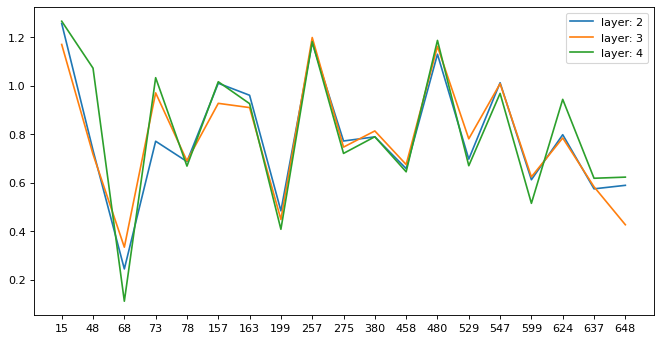

In [37]:
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(str_bothuserId, rmse_layer2, label = "layer: 2")
plt.plot(str_bothuserId, rmse_input512, label = "layer: 3")
plt.plot(str_bothuserId, rmse_layer4, label = "layer: 4")

plt.legend()
plt.show()

In [39]:
print(np.mean(rmse_layer2))
print(np.mean(rmse_input512))
print(np.mean(rmse_layer4))

0.7869502
0.78765357
0.8082953


# Epoch

In [65]:
epoch5 = all_neumf_layer2()
epoch20 = all_neumf_layer2()
epoch30 = all_neumf_layer2()

epoch20.load_state_dict(torch.load('saved_models/neuCF_20_lr0.0001_m0.9_input512_layer2'))
epoch5.load_state_dict(torch.load('saved_models/neuCF_5_lr0.0001_m0.9_input512_layer2'))
epoch30.load_state_dict(torch.load('saved_models/neuCF_30_lr0.0001_m0.9_input512_layer2'))

epoch5.to(device)
epoch20.to(device)
epoch30.to(device)


all_neumf_layer2(
  (mlp): MLP_layer2(
    (fc1): Linear(in_features=800, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=400, bias=True)
  )
  (neumf): Linear(in_features=800, out_features=1, bias=True)
)

In [66]:
rmse_epoch5 = []
rmse_epoch20 = []
rmse_epoch30 = []

for i in new_bothuserId:
    rmse_epoch5.append((RMSE_neuf(i, epoch5)[0][0]))
    rmse_epoch20.append((RMSE_neuf(i, epoch20)[0][0]))
    rmse_epoch30.append((RMSE_neuf(i, epoch30)[0][0]))

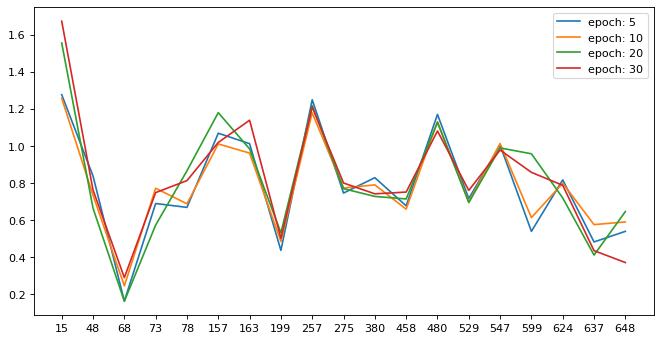

In [67]:
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(str_bothuserId, rmse_epoch5, label = "epoch: 5")
plt.plot(str_bothuserId, rmse_layer2, label = "epoch: 10")
plt.plot(str_bothuserId, rmse_epoch20, label = "epoch: 20")
plt.plot(str_bothuserId, rmse_epoch30, label = "epoch: 30")

plt.legend()
plt.show()

In [68]:
print(np.mean(rmse_epoch5))
print(np.mean(rmse_layer2))
print(np.mean(rmse_epoch20))
print(np.mean(rmse_epoch30))

0.7842137
0.7869502
0.8141363
0.82616925


In [76]:
#final model to param.data
#torch.save(epoch5.state_dict(), "param.data")

In [82]:
format(0.2, ".3f")

'0.200'

In [88]:
finalmodel_loss = pickle.load(open('saved_loss/avg_loss_list_neuCF_5_lr0.0001_m0.9_input512_layer2', "rb"))
finalmodel_loss

[tensor(1.1321, device='cuda:0', requires_grad=True),
 tensor(0.9389, device='cuda:0', requires_grad=True),
 tensor(0.8797, device='cuda:0', requires_grad=True),
 tensor(0.8531, device='cuda:0', requires_grad=True),
 tensor(0.8408, device='cuda:0', requires_grad=True)]

In [110]:
f_loss_list = []
epoch_axis = []

epoch_count = 1
for i in finalmodel_loss:
    epoch_axis.append(str(epoch_count))
    epoch_count += 1
    f_loss_list.append(i.detach().cpu().numpy())



In [111]:
f_loss_list

[array(1.1321304, dtype=float32),
 array(0.93887687, dtype=float32),
 array(0.8797234, dtype=float32),
 array(0.853099, dtype=float32),
 array(0.8407891, dtype=float32)]

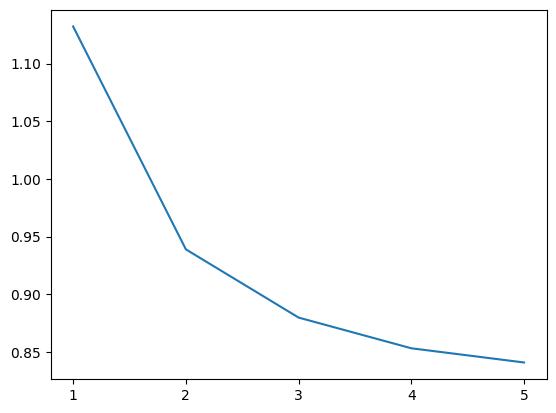

In [112]:
plt.plot(epoch_axis, f_loss_list)
plt.show()